# Kaggle Project

## Describe Your Dataset

**URL:** https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

**Task:** 

데이터 세트의 환자가 당뇨병이 있는지 여부를 예측하기 위한 모델 구축. 

이를 위해 5가지 모델을 구축해보고자 함
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* SVC
* Neural Network


**Datasets**

이 데이터 세트는 피마 인디언 혈통인 최소 21세 이상의 여성들로부터 환자의 임신 횟수, BMI, 인슐린 수치, 연령 등 특정 측정을 기반으로 환자가 당뇨병이 있는지 여부를 예측하는 것을 목적으로 구성됨.

총 768개의 환자 데이터로 구성되어 있으며, Train:Validation:Test=6:2:2 비율로 나눠서 진행하려고 함.

* Train dataset: 60%(460개)

* Validation dataset: 20%(154개)

* Test dataset: 20%(154개)

**Features(x):**

8가지 feature로 구성

* Pregnancies: 임신 횟수
* Glucose: 경구 포도당 부하검사 2시간 후 혈장 포도당 농도
* BloodPressure: 이완기 혈압(mm Hg)
* SkinThickness: 삼두근 피부 두께(mm)
* Insulin: 식후 2시간 후 혈청 인슐린(mu U/ml)
* BMI: 체질량 지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨병 혈통 함수
* Age: 연령(세)

**Target(y):**

2가지 class로 분류

* 0: 당뇨병이 아닌 환자
* 1: 당뇨병 환자

---

## Build Your Model

In [75]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

### Data preprocessing

In [2]:
# Raw Data
rData = pd.read_csv('/Users/dahyun/Downloads/archive/diabetes.csv')
rData

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# Data balance 확인
rData['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [4]:
# Missing values 확인
rData.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [140]:
# Feature와 target을 분리
X = rData.drop('Outcome', axis=1)
y = rData['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

### Model Construction

In [141]:
# Neural Network 모델을 위한 class 선언
# 8->4->1 차원으로 설정, 2개의 fully connected layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8,4)
        self.fc2 = nn.Linear(4,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### Train Model & Select Model

**Logistic Regression**

In [7]:
# GridSearchCV를 이용한 하이퍼 파라미터 튜닝
params = {'C':[0.5,1,3,5,7,10],
          'max_iter':[50,100,200,300,500]}
lr = LogisticRegression(random_state=0)
gs = GridSearchCV(lr, params, cv=5, n_jobs=-1)
gs.fit(X_train_sc, y_train)

print('최적 하이퍼 파라미터:',gs.best_params_)

최적 하이퍼 파라미터: {'C': 0.5, 'max_iter': 50}


--------------------------------------------------
Accuracy score of Logistic regression
--------------------------------------------------
Train: 78.26%
Validation: 74.68%
Test: 83.77%
--------------------------------------------------


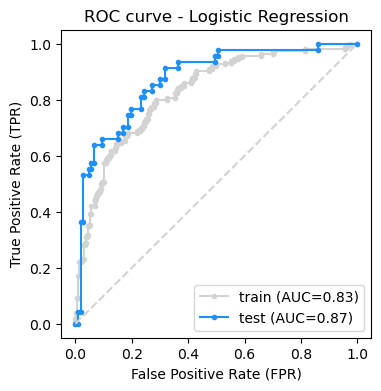

In [8]:
lr = LogisticRegression(C=0.5, max_iter=50, random_state=0)

lr.fit(X_train_sc, y_train)

# Accuracy Score 출력
print('-'*50)
print('Accuracy score of Logistic regression')
print('-'*50)

pre = lr.predict(X_train_sc)
print(f'Train: {round(accuracy_score(y_train, pre)*100,2)}%')

pre = lr.predict(X_val_sc)
print(f'Validation: {round(accuracy_score(y_val, pre)*100,2)}%')

pre = lr.predict(X_test_sc)
print(f'Test: {round(accuracy_score(y_test, pre)*100,2)}%')
print('-'*50)

# ROC curve 생성
lr_train_probs = lr.predict_proba(X_train_sc)[:,1]
lr_test_probs = lr.predict_proba(X_test_sc)[:,1]

lr_train_fpr, lr_train_tpr, lr_train_ = roc_curve(y_train, lr_train_probs)
lr_test_fpr, lr_test_tpr, lr_test_ = roc_curve(y_test, lr_test_probs)

plt.figure(figsize=(4,4))
plt.plot(lr_train_fpr, lr_train_tpr, color='lightgray', marker='.', label=f'train (AUC={round(roc_auc_score(y_train, lr_train_probs),2)})')
plt.plot(lr_test_fpr, lr_test_tpr, color='dodgerblue', marker='.', label=f'test (AUC={round(roc_auc_score(y_test, lr_test_probs),2)})')
plt.plot([0,1],[0,1], color='lightgray',linestyle='--')
plt.title('ROC curve - Logistic Regression')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

**Decision Tree Classifier**

In [9]:
# GridSearchCV를 이용한 하이퍼 파라미터 튜닝
params = {'criterion' : ['gini','entropy'],
          'splitter' : ['best','random'],
          'max_depth' : [i for i in range(1,10)],
          'min_samples_split' : [i for i in range(2,10)]}
dtc = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(dtc, params, cv=5, n_jobs=-1)
gs.fit(X_train_sc, y_train)

print('최적 하이퍼 파라미터:',gs.best_params_)

최적 하이퍼 파라미터: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2, 'splitter': 'best'}


--------------------------------------------------
Accuracy score of Decision Tree Classifier
--------------------------------------------------
Train: 77.17%
Validation: 74.03%
Test: 76.62%
--------------------------------------------------


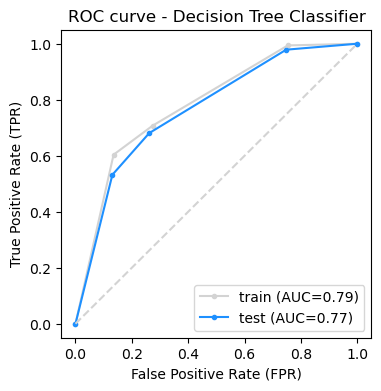

In [10]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=2, splitter='best', random_state=0)

dtc.fit(X_train_sc, y_train)

# Accuracy Score 출력
print('-'*50)
print('Accuracy score of Decision Tree Classifier')
print('-'*50)

pre = dtc.predict(X_train_sc)
print(f'Train: {round(accuracy_score(y_train, pre)*100,2)}%')

pre = dtc.predict(X_val_sc)
print(f'Validation: {round(accuracy_score(y_val, pre)*100,2)}%')

pre = dtc.predict(X_test_sc)
print(f'Test: {round(accuracy_score(y_test, pre)*100,2)}%')
print('-'*50)

# ROC curve 생성
dtc_train_probs = dtc.predict_proba(X_train_sc)[:,1]
dtc_test_probs = dtc.predict_proba(X_test_sc)[:,1]

dtc_train_fpr, dtc_train_tpr, dtc_train_ = roc_curve(y_train, dtc_train_probs)
dtc_test_fpr, dtc_test_tpr, dtc_test_ = roc_curve(y_test, dtc_test_probs)

plt.figure(figsize=(4,4))
plt.plot(dtc_train_fpr, dtc_train_tpr, color='lightgray', marker='.', label=f'train (AUC={round(roc_auc_score(y_train, dtc_train_probs),2)})')
plt.plot(dtc_test_fpr, dtc_test_tpr, color='dodgerblue', marker='.', label=f'test (AUC={round(roc_auc_score(y_test, dtc_test_probs),2)})')
plt.plot([0,1],[0,1], color='lightgray',linestyle='--')
plt.title('ROC curve - Decision Tree Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

**Random Forest Classifier**

In [11]:
# GridSearchCV를 이용한 하이퍼 파라미터 튜닝
params = {'n_estimators' : [10, 50, 100, 150, 200],
          'max_depth' : [i for i in range(1,10)],
          'min_samples_leaf' : [i for i in range(1,10)],
          'min_samples_split' : [i for i in range(2,10)]}
rfc = RandomForestClassifier(random_state=0)
gs = GridSearchCV(rfc, params, cv=5, n_jobs=-1)
gs.fit(X_train_sc, y_train)

print('최적 하이퍼 파라미터:',gs.best_params_)

최적 하이퍼 파라미터: {'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 10}


--------------------------------------------------
Accuracy score of Random Forest Classifier
--------------------------------------------------
Train: 83.91%
Validation: 74.68%
Test: 84.42%
--------------------------------------------------


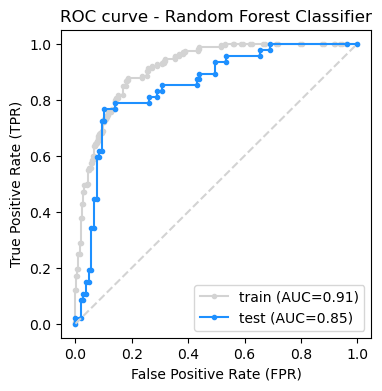

In [12]:
rfc = RandomForestClassifier(max_depth=9, min_samples_leaf=9, min_samples_split=2, n_estimators=10, random_state=0)

rfc.fit(X_train_sc, y_train)

# Accuracy Score 출력
print('-'*50)
print('Accuracy score of Random Forest Classifier')
print('-'*50)

pre = rfc.predict(X_train_sc)
print(f'Train: {round(accuracy_score(y_train, pre)*100,2)}%')

pre = rfc.predict(X_val_sc)
print(f'Validation: {round(accuracy_score(y_val, pre)*100,2)}%')

pre = rfc.predict(X_test_sc)
print(f'Test: {round(accuracy_score(y_test, pre)*100,2)}%')
print('-'*50)

# ROC curve 생성
rfc_train_probs = rfc.predict_proba(X_train_sc)[:,1]
rfc_test_probs = rfc.predict_proba(X_test_sc)[:,1]

rfc_train_fpr, rfc_train_tpr, rfc_train_ = roc_curve(y_train, rfc_train_probs)
rfc_test_fpr, rfc_test_tpr, rfc_test_ = roc_curve(y_test, rfc_test_probs)

plt.figure(figsize=(4,4))
plt.plot(rfc_train_fpr, rfc_train_tpr, color='lightgray', marker='.', label=f'train (AUC={round(roc_auc_score(y_train, rfc_train_probs),2)})')
plt.plot(rfc_test_fpr, rfc_test_tpr, color='dodgerblue', marker='.', label=f'test (AUC={round(roc_auc_score(y_test, rfc_test_probs),2)})')
plt.plot([0,1],[0,1], color='lightgray',linestyle='--')
plt.title('ROC curve - Random Forest Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

**SVC**

In [13]:
# GridSearchCV를 이용한 하이퍼 파라미터 튜닝
params = {'C':[0.01, 0.1, 1, 10],
          'kernel':['linear', 'rbf'],
          'gamma':['scale','auto']}
svc = SVC(random_state=0)
gs = GridSearchCV(svc, params, cv=5, n_jobs=-1)
gs.fit(X_train_sc, y_train)

print('최적 하이퍼 파라미터:',gs.best_params_)

최적 하이퍼 파라미터: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


--------------------------------------------------
Accuracy score of SVC
--------------------------------------------------
Train: 76.96%
Validation: 74.68%
Test: 84.42%
--------------------------------------------------


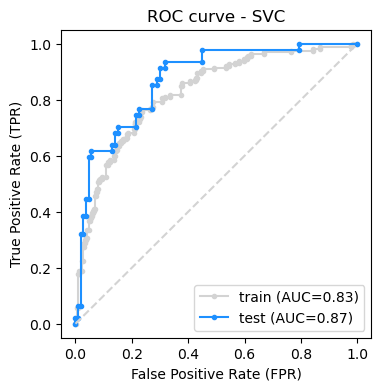

In [14]:
svc = SVC(C=0.01, gamma='scale', kernel='linear', probability=True, random_state=0)

svc.fit(X_train_sc, y_train)

# Accuracy Score 출력
print('-'*50)
print('Accuracy score of SVC')
print('-'*50)

pre = svc.predict(X_train_sc)
print(f'Train: {round(accuracy_score(y_train, pre)*100,2)}%')

pre = svc.predict(X_val_sc)
print(f'Validation: {round(accuracy_score(y_val, pre)*100,2)}%')

pre = svc.predict(X_test_sc)
print(f'Test: {round(accuracy_score(y_test, pre)*100,2)}%')
print('-'*50)

# ROC curve 생성
svc_train_probs = svc.predict_proba(X_train_sc)[:,1]
svc_test_probs = svc.predict_proba(X_test_sc)[:,1]

svc_train_fpr, svc_train_tpr, svc_train_ = roc_curve(y_train, svc_train_probs)
svc_test_fpr, svc_test_tpr, svc_test_ = roc_curve(y_test, svc_test_probs)

plt.figure(figsize=(4,4))
plt.plot(svc_train_fpr, svc_train_tpr, color='lightgray', marker='.', label=f'train (AUC={round(roc_auc_score(y_train, svc_train_probs),2)})')
plt.plot(svc_test_fpr, svc_test_tpr, color='dodgerblue', marker='.', label=f'test (AUC={round(roc_auc_score(y_test, svc_test_probs),2)})')
plt.plot([0,1],[0,1], color='lightgray',linestyle='--')
plt.title('ROC curve - SVC')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

**Neural Network**

In [144]:
torch.manual_seed(0)
net = Net()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net.parameters(),lr=0.01) # 보통 Adam을 쓴다고 하여 Adam으로 진행

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.4292
Epoch [2000/10000], Loss: 0.4115
Epoch [3000/10000], Loss: 0.4033
Epoch [4000/10000], Loss: 0.3970
Epoch [5000/10000], Loss: 0.3928
Epoch [6000/10000], Loss: 0.3899
Epoch [7000/10000], Loss: 0.3877
Epoch [8000/10000], Loss: 0.3859
Epoch [9000/10000], Loss: 0.3841
Epoch [10000/10000], Loss: 0.3818


In [145]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net.eval()
with torch.no_grad():
    outputs = net(X_val_ts)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy.item()*100,2)}%')

with torch.no_grad():
    outputs = net(X_test_ts)
    predicted = torch.round(outputs)
    accuracy = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 74.03%
Test: 73.38%
--------------------------------------------------


---

## Performance

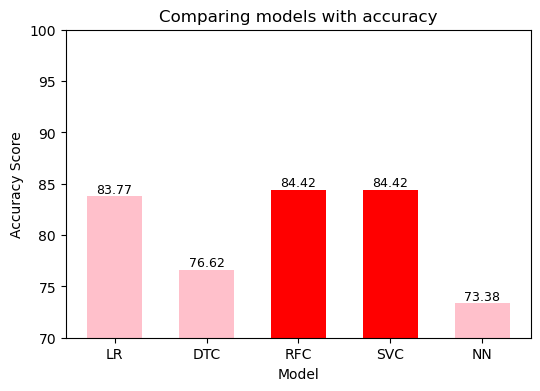

In [146]:
# 위에서 구축한 5가지 모델의 정확도 비교
x = ['LR','DTC','RFC','SVC','NN']
y = [83.77, 76.62, 84.42, 84.42, round(accuracy.item()*100,2)]

# Bar plot 생성
plt.figure(figsize=(6,4))
plt.title('Comparing models with accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.bar(x, y, width=0.6, color=['pink','pink','red','red','pink'])
plt.ylim(70,100)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize = 9,
            horizontalalignment='center',
            verticalalignment='bottom')

---

## Summary

* Data Preprocessing = StandardScaler사용하여 표준화

* 모델 구축 시 사용 알고리즘 = 머신러닝 알고리즘 4가지(Logistic Regression, Decision Tree Classifier, Random Forest Classifier, Support Vector Classification), 딥러닝 알고리즘 1가지(Neural Network)

* 머신러닝 = GridSearchCV로 하이퍼파라미터 튜닝

* 딥러닝 = 8->4->1차원으로 진행, Fully connected layer, activation function = Sigmoid, Loss function = BCE, Optimizer = Adam

---

### 1. 특정 값을 제거한다면?

In [18]:
rData.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [19]:
Data = rData.copy(deep=True)
Data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = Data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)
Data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [20]:
Data = Data.dropna(axis=0)
Data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181.0,88.0,44.0,510.0,43.3,0.222,26,1
755,1,128.0,88.0,39.0,110.0,36.5,1.057,37,1
760,2,88.0,58.0,26.0,16.0,28.4,0.766,22,0
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0


In [21]:
Data['Outcome'].value_counts()

0    262
1    130
Name: Outcome, dtype: int64

In [147]:
# Feature와 target을 분리
X = Data.drop('Outcome', axis=1)
y = Data['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

In [149]:
torch.manual_seed(0)
net = Net()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net.parameters(),lr=0.01) # 보통 Adam을 쓴다고 하여 Adam으로 진행

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.3118
Epoch [2000/10000], Loss: 0.2795
Epoch [3000/10000], Loss: 0.2680
Epoch [4000/10000], Loss: 0.2601
Epoch [5000/10000], Loss: 0.2543
Epoch [6000/10000], Loss: 0.2495
Epoch [7000/10000], Loss: 0.2455
Epoch [8000/10000], Loss: 0.2422
Epoch [9000/10000], Loss: 0.2396
Epoch [10000/10000], Loss: 0.2373


In [150]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net.eval()
with torch.no_grad():
    outputs = net(X_val_ts)
    predicted = torch.round(outputs)
    accuracy2 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy.item()*100,2)}%')

with torch.no_grad():
    outputs = net(X_test_ts)
    predicted = torch.round(outputs)
    accuracy2 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy2.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 73.38%
Test: 81.01%
--------------------------------------------------


### Performance

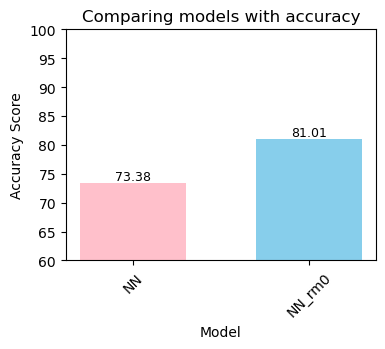

In [151]:
x = ['NN','NN_rm0']
y = [round(accuracy.item()*100,2), round(accuracy2.item()*100,2)]

# Bar plot 생성
plt.figure(figsize=(4,3))
plt.title('Comparing models with accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.bar(x, y, width=0.6, color=['pink','skyblue'])
plt.xticks(rotation=45)
plt.ylim(60,100)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize = 9,
            horizontalalignment='center',
            verticalalignment='bottom')

---

### 2. Scaler에 변화를 준다면?

In [26]:
Data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

([<matplotlib.axis.XTick at 0x1c85c09cb50>,
 [Text(1, 0, 'Pregnancies'),
  Text(2, 0, 'Glucose'),
  Text(3, 0, 'BloodPressure'),
  Text(4, 0, 'SkinThickness'),
  Text(5, 0, 'Insulin'),
  Text(6, 0, 'BMI'),
  Text(7, 0, 'DiabetesPedigreeFunction'),
  Text(8, 0, 'Age'),
  Text(9, 0, 'Outcome')])

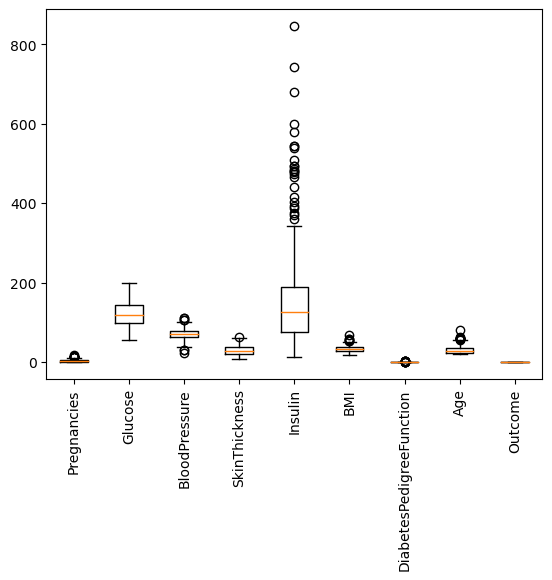

In [27]:
idx = np.arange(1,10)
labels= ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
plt.boxplot(Data)
plt.xticks(idx, labels, rotation=90)

In [152]:
# Feature와 target을 분리
X = Data.drop('Outcome', axis=1)
y = Data['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = RobustScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

In [153]:
torch.manual_seed(0)
net = Net()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net.parameters(),lr=0.01) # 보통 Adam을 쓴다고 하여 Adam으로 진행

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.2922
Epoch [2000/10000], Loss: 0.2096
Epoch [3000/10000], Loss: 0.1952
Epoch [4000/10000], Loss: 0.1840
Epoch [5000/10000], Loss: 0.1751
Epoch [6000/10000], Loss: 0.1703
Epoch [7000/10000], Loss: 0.1673
Epoch [8000/10000], Loss: 0.1652
Epoch [9000/10000], Loss: 0.1635
Epoch [10000/10000], Loss: 0.1622


In [154]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net.eval()
with torch.no_grad():
    outputs = net(X_val_ts)
    predicted = torch.round(outputs)
    accuracy3 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy.item()*100,2)}%')

with torch.no_grad():
    outputs = net(X_test_ts)
    predicted = torch.round(outputs)
    accuracy3 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy3.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 73.38%
Test: 79.75%
--------------------------------------------------


**Performance**

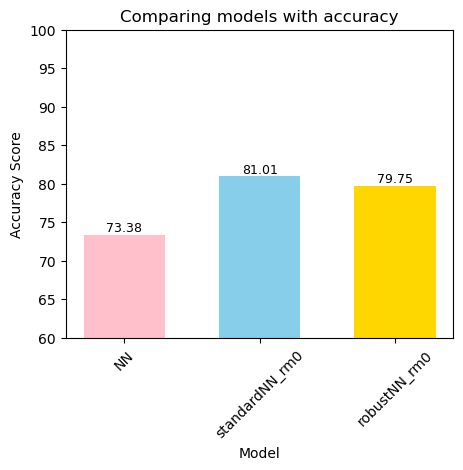

In [155]:
x = ['NN','standardNN_rm0','robustNN_rm0']
y = [round(accuracy.item()*100,2), round(accuracy2.item()*100,2),round(accuracy3.item()*100,2)]

# Bar plot 생성
plt.figure(figsize=(5,4))
plt.title('Comparing models with accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.bar(x, y, width=0.6, color=['pink','skyblue','gold'])
plt.xticks(rotation=45)
plt.ylim(60,100)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize = 9,
            horizontalalignment='center',
            verticalalignment='bottom')

---

### 3. Hidden layer를 바꾼다면?

In [188]:
# Feature와 target을 분리
X = Data.drop('Outcome', axis=1)
y = Data['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

**Model1: 8->6->3->1 (hidden layer의 개수 변경)**

In [189]:
class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(8,6)
        self.fc2 = nn.Linear(6,3)
        self.fc3 = nn.Linear(3,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [190]:
torch.manual_seed(0)
m1 = M1()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(m1.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = m1(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.1660
Epoch [2000/10000], Loss: 0.1241
Epoch [3000/10000], Loss: 0.1108
Epoch [4000/10000], Loss: 0.0793
Epoch [5000/10000], Loss: 0.0758
Epoch [6000/10000], Loss: 0.0733
Epoch [7000/10000], Loss: 0.0718
Epoch [8000/10000], Loss: 0.0709
Epoch [9000/10000], Loss: 0.0701
Epoch [10000/10000], Loss: 0.0678


In [191]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
m1.eval()
with torch.no_grad():
    outputs = m1(X_val_ts)
    predicted = torch.round(outputs)
    accuracy4 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy4.item()*100,2)}%')

with torch.no_grad():
    outputs = m1(X_test_ts)
    predicted = torch.round(outputs)
    accuracy4 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy4.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 74.68%
Test: 79.75%
--------------------------------------------------


**Model2:8->16->1 (hidden layer의 차원 변경)**

In [192]:
class M2(nn.Module):
    def __init__(self):
        super(M2, self).__init__()
        self.fc1 = nn.Linear(8,16)
        self.fc2 = nn.Linear(16,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [193]:
torch.manual_seed(0)
m2 = M2()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(m2.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = m2(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.0400
Epoch [2000/10000], Loss: 0.0086
Epoch [3000/10000], Loss: 0.0033
Epoch [4000/10000], Loss: 0.0016
Epoch [5000/10000], Loss: 0.0008
Epoch [6000/10000], Loss: 0.0005
Epoch [7000/10000], Loss: 0.0003
Epoch [8000/10000], Loss: 0.0002
Epoch [9000/10000], Loss: 0.0001
Epoch [10000/10000], Loss: 0.0001


In [194]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
m2.eval()
with torch.no_grad():
    outputs = m2(X_val_ts)
    predicted = torch.round(outputs)
    accuracy5 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy5.item()*100,2)}%')

with torch.no_grad():
    outputs = m2(X_test_ts)
    predicted = torch.round(outputs)
    accuracy5 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy5.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 75.95%
Test: 79.75%
--------------------------------------------------


In [195]:
# Feature와 target을 분리
X = Data.drop('Outcome', axis=1)
y = Data['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = RobustScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

In [196]:
torch.manual_seed(0)
m1 = M1()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(m1.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = m1(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.1957
Epoch [2000/10000], Loss: 0.1658
Epoch [3000/10000], Loss: 0.1063
Epoch [4000/10000], Loss: 0.0870
Epoch [5000/10000], Loss: 0.0760
Epoch [6000/10000], Loss: 0.0537
Epoch [7000/10000], Loss: 0.0521
Epoch [8000/10000], Loss: 0.0513
Epoch [9000/10000], Loss: 0.0503
Epoch [10000/10000], Loss: 0.0467


In [197]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
m1.eval()
with torch.no_grad():
    outputs = m1(X_val_ts)
    predicted = torch.round(outputs)
    accuracy6 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy6.item()*100,2)}%')

with torch.no_grad():
    outputs = m1(X_test_ts)
    predicted = torch.round(outputs)
    accuracy6 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy6.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 64.56%
Test: 68.35%
--------------------------------------------------


In [198]:
torch.manual_seed(0)
m2 = M2()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(m2.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = m2(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.0498
Epoch [2000/10000], Loss: 0.0068
Epoch [3000/10000], Loss: 0.0024
Epoch [4000/10000], Loss: 0.0011
Epoch [5000/10000], Loss: 0.0006
Epoch [6000/10000], Loss: 0.0003
Epoch [7000/10000], Loss: 0.0002
Epoch [8000/10000], Loss: 0.0001
Epoch [9000/10000], Loss: 0.0001
Epoch [10000/10000], Loss: 0.0000


In [199]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
m2.eval()
with torch.no_grad():
    outputs = m2(X_val_ts)
    predicted = torch.round(outputs)
    accuracy7 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy7.item()*100,2)}%')

with torch.no_grad():
    outputs = m2(X_test_ts)
    predicted = torch.round(outputs)
    accuracy7 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy7.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 75.95%
Test: 81.01%
--------------------------------------------------


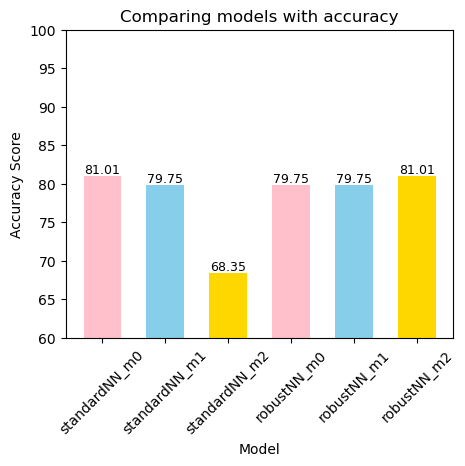

In [184]:
x = ['standardNN_m0','standardNN_m1','standardNN_m2','robustNN_m0','robustNN_m1','robustNN_m2']
y = [round(accuracy2.item()*100,2),round(accuracy4.item()*100,2),round(accuracy6.item()*100,2),
     round(accuracy3.item()*100,2),round(accuracy5.item()*100,2),round(accuracy7.item()*100,2)]

# Bar plot 생성
plt.figure(figsize=(5,4))
plt.title('Comparing models with accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.bar(x, y, width=0.6, color=['pink','skyblue','gold'])
plt.xticks(rotation=45)
plt.ylim(60,100)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize = 9,
            horizontalalignment='center',
            verticalalignment='bottom')

---

### 4. Activation Function을 바꾼다면?

In [136]:
import torch.nn.functional as F

In [217]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(8,4)
        self.fc2 = nn.Linear(4,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [218]:
# Feature와 target을 분리
X = Data.drop('Outcome', axis=1)
y = Data['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

In [219]:
torch.manual_seed(0)
net2 = Net2()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net2.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net2(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.3685
Epoch [2000/10000], Loss: 0.3678
Epoch [3000/10000], Loss: 0.3678
Epoch [4000/10000], Loss: 0.3679
Epoch [5000/10000], Loss: 0.3679
Epoch [6000/10000], Loss: 0.3678
Epoch [7000/10000], Loss: 0.3678
Epoch [8000/10000], Loss: 0.3679
Epoch [9000/10000], Loss: 0.3679
Epoch [10000/10000], Loss: 0.3678


In [228]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net2.eval()
with torch.no_grad():
    outputs = net2(X_val_ts)
    predicted = torch.round(outputs)
    accuracy8 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy8.item()*100,2)}%')

with torch.no_grad():
    outputs = net2(X_test_ts)
    predicted = torch.round(outputs)
    accuracy8 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy8.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 55.7%
Test: 56.96%
--------------------------------------------------


In [221]:
class Net2_1(nn.Module):
    def __init__(self):
        super(Net2_1, self).__init__()
        self.fc1 = nn.Linear(8,6)
        self.fc2 = nn.Linear(6,3)
        self.fc3 = nn.Linear(3,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [224]:
torch.manual_seed(0)
net2_1 = Net2_1()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net2_1.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net2_1(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.1512
Epoch [2000/10000], Loss: 0.1355
Epoch [3000/10000], Loss: 0.1281
Epoch [4000/10000], Loss: 0.1217
Epoch [5000/10000], Loss: 0.1131
Epoch [6000/10000], Loss: 0.1088
Epoch [7000/10000], Loss: 0.1191
Epoch [8000/10000], Loss: 0.0951
Epoch [9000/10000], Loss: 0.0914
Epoch [10000/10000], Loss: 0.0900


In [229]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net2_1.eval()
with torch.no_grad():
    outputs = net2_1(X_val_ts)
    predicted = torch.round(outputs)
    accuracy9 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy9.item()*100,2)}%')

with torch.no_grad():
    outputs = net2_1(X_test_ts)
    predicted = torch.round(outputs)
    accuracy9 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy9.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 75.95%
Test: 73.42%
--------------------------------------------------


In [230]:
class Net2_2(nn.Module):
    def __init__(self):
        super(Net2_2, self).__init__()
        self.fc1 = nn.Linear(8,16)
        self.fc2 = nn.Linear(16,1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [231]:
torch.manual_seed(0)
net2_2 = Net2_2()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net2_2.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net2_2(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.0207
Epoch [2000/10000], Loss: 0.0026
Epoch [3000/10000], Loss: 0.0008
Epoch [4000/10000], Loss: 0.0003
Epoch [5000/10000], Loss: 0.0002
Epoch [6000/10000], Loss: 0.0001
Epoch [7000/10000], Loss: 0.0000
Epoch [8000/10000], Loss: 0.0000
Epoch [9000/10000], Loss: 0.0000
Epoch [10000/10000], Loss: 0.0000


In [232]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net2_2.eval()
with torch.no_grad():
    outputs = net2_2(X_val_ts)
    predicted = torch.round(outputs)
    accuracy10 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy10.item()*100,2)}%')

with torch.no_grad():
    outputs = net2_2(X_test_ts)
    predicted = torch.round(outputs)
    accuracy10 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy10.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 70.89%
Test: 72.15%
--------------------------------------------------


In [233]:
# Feature와 target을 분리
X = Data.drop('Outcome', axis=1)
y = Data['Outcome']

# Train, Validation, Test set을 6:2:2 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=0)

# Data scaling
sc = RobustScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network 모델을 위해 Tensor로 전환
X_train_ts = torch.from_numpy(X_train_sc).float()
X_val_ts = torch.from_numpy(X_val_sc).float()
X_test_ts = torch.from_numpy(X_test_sc).float()

y_train_ts = y_train.values
y_val_ts = y_val.values
y_test_ts = y_test.values

y_train_ts = torch.from_numpy(y_train_ts).float()
y_val_ts = torch.from_numpy(y_val_ts).float()
y_test_ts = torch.from_numpy(y_test_ts).float()

In [234]:
torch.manual_seed(0)
net2 = Net2()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net2.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net2(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.3780
Epoch [2000/10000], Loss: 0.3749
Epoch [3000/10000], Loss: 0.3749
Epoch [4000/10000], Loss: 0.3749
Epoch [5000/10000], Loss: 0.3748
Epoch [6000/10000], Loss: 0.3747
Epoch [7000/10000], Loss: 0.3748
Epoch [8000/10000], Loss: 0.3748
Epoch [9000/10000], Loss: 0.3748
Epoch [10000/10000], Loss: 0.3748


In [240]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net2.eval()
with torch.no_grad():
    outputs = net2(X_val_ts)
    predicted = torch.round(outputs)
    accuracy11 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy11.item()*100,2)}%')

with torch.no_grad():
    outputs = net2(X_test_ts)
    predicted = torch.round(outputs)
    accuracy11 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy11.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 78.48%
Test: 74.68%
--------------------------------------------------


In [236]:
torch.manual_seed(0)
net2_1 = Net2_1()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net2_1.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net2_1(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.1485
Epoch [2000/10000], Loss: 0.1313
Epoch [3000/10000], Loss: 0.1268
Epoch [4000/10000], Loss: 0.1232
Epoch [5000/10000], Loss: 0.1210
Epoch [6000/10000], Loss: 0.1203
Epoch [7000/10000], Loss: 0.1194
Epoch [8000/10000], Loss: 0.1188
Epoch [9000/10000], Loss: 0.1178
Epoch [10000/10000], Loss: 0.0971


In [241]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net2_1.eval()
with torch.no_grad():
    outputs = net2_1(X_val_ts)
    predicted = torch.round(outputs)
    accuracy12 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy12.item()*100,2)}%')

with torch.no_grad():
    outputs = net2_1(X_test_ts)
    predicted = torch.round(outputs)
    accuracy12 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy12.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 70.89%
Test: 77.22%
--------------------------------------------------


In [238]:
torch.manual_seed(0)
net2_2 = Net2_2()
loss = nn.BCELoss() # Loss 함수는 BCE
optimizer = optim.Adam(net2_2.parameters(),lr=0.01)

num_epochs = 10000

for epoch in range(num_epochs):
   
    pre = net2_2(X_train_ts)
    cost = loss(pre, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, cost.item()))

Epoch [1000/10000], Loss: 0.0852
Epoch [2000/10000], Loss: 0.0210
Epoch [3000/10000], Loss: 0.0086
Epoch [4000/10000], Loss: 0.0039
Epoch [5000/10000], Loss: 0.0019
Epoch [6000/10000], Loss: 0.0010
Epoch [7000/10000], Loss: 0.0005
Epoch [8000/10000], Loss: 0.0003
Epoch [9000/10000], Loss: 0.0002
Epoch [10000/10000], Loss: 0.0001


In [242]:
print('-'*50)
print('Accuracy score of Neural Network')
print('-'*50)

# 모델 평가 및 정확도 출력
net2_2.eval()
with torch.no_grad():
    outputs = net2_2(X_val_ts)
    predicted = torch.round(outputs)
    accuracy13 = (predicted == y_val_ts.view(-1, 1)).sum().float() / len(y_val_ts)
    print(f'Validation: {round(accuracy13.item()*100,2)}%')

with torch.no_grad():
    outputs = net2_2(X_test_ts)
    predicted = torch.round(outputs)
    accuracy13 = (predicted == y_test_ts.view(-1, 1)).sum().float() / len(y_test_ts)
    print(f'Test: {round(accuracy13.item()*100,2)}%')

print('-'*50)

--------------------------------------------------
Accuracy score of Neural Network
--------------------------------------------------
Validation: 68.35%
Test: 78.48%
--------------------------------------------------


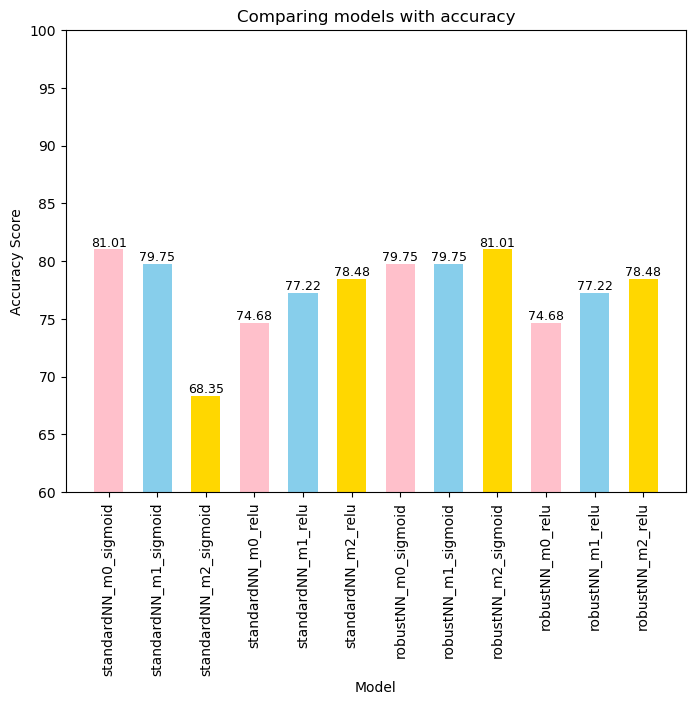

In [254]:
x = ['standardNN_m0_sigmoid','standardNN_m1_sigmoid','standardNN_m2_sigmoid',
     'standardNN_m0_relu','standardNN_m1_relu','standardNN_m2_relu',
     'robustNN_m0_sigmoid','robustNN_m1_sigmoid','robustNN_m2_sigmoid',
     'robustNN_m0_relu','robustNN_m1_relu','robustNN_m2_relu']
y = [round(accuracy2.item()*100,2),round(accuracy4.item()*100,2),round(accuracy6.item()*100,2),
     round(accuracy8.item()*100,2),round(accuracy9.item()*100,2),round(accuracy10.item()*100,2),
     round(accuracy3.item()*100,2),round(accuracy5.item()*100,2),round(accuracy7.item()*100,2),
     round(accuracy11.item()*100,2),round(accuracy12.item()*100,2),round(accuracy13.item()*100,2)]

# Bar plot 생성
plt.figure(figsize=(8,6))
plt.title('Comparing models with accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.bar(x, y, width=0.6, color=['pink','skyblue','gold'])
plt.xticks(rotation=90)
plt.ylim(60,100)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize = 9,
            horizontalalignment='center',
            verticalalignment='bottom')

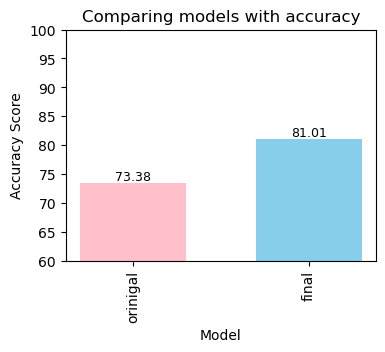

In [257]:
x = ['orinigal','final']
y = [round(accuracy.item()*100,2),round(accuracy2.item()*100,2)]

# Bar plot 생성
plt.figure(figsize=(4,3))
plt.title('Comparing models with accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.bar(x, y, width=0.6, color=['pink','skyblue'])
plt.xticks(rotation=90)
plt.ylim(60,100)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize = 9,
            horizontalalignment='center',
            verticalalignment='bottom')